In [1]:
import os
import torch
import pickle
import mujoco
import mujoco.viewer
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from agent import SACAgent
from utils import ReplayBuffer
from trainer import SACTrainer

# This solve the pendulum environment with soft actor critic algorithm

# It uses a bunch of tricks to make this work better:
# Twin Q-Networks
# Memory Replay (Experience Replay Buffer)
# Target Networks with Polyak Averaging
# Automatic Entropy Tuning
# Reparameterization Trick
# Tanh Action Squashing with Log-Probability Correction
# Gradient Clipping
# Random Action Initialization

In [ ]:
class SequentialReachingEnv(gym.Env):
    """Custom 2-Joint Limb with 4 Muscles, 12 Sensors, and a Target Position"""

    def __init__(
        self,
        xml_file="your_model.xml",
        max_num_targets=10,
        max_target_duration=3,
    ):
        super().__init__()

        mj_dir = "../mujoco"
        xml_path = os.path.join(mj_dir, xml_file)
        self.model = mujoco.MjModel.from_xml_path(xml_path)
        self.data = mujoco.MjData(self.model)
        self.max_num_targets = max_num_targets
        self.max_target_duration = max_target_duration
        self.viewer = None

        # Get the site ID using the name of your end effector
        self.hand_id = self.model.geom("hand").id
        
        # Load sensor stats
        sensor_stats_path = os.path.join(mj_dir, "sensor_stats.pkl")
        with open(sensor_stats_path, "rb") as f:
            self.sensor_stats = pickle.load(f)

        # Load target stats
        target_stats_path = os.path.join(mj_dir, "target_stats.pkl")
        with open(target_stats_path, "rb") as f:
            self.target_stats = pickle.load(f)

        # Define the lower and upper bounds for each feature (15 features)
        low_values = np.concatenate(
            [
                self.sensor_stats["min"].values,
                self.target_stats["min"].values,
            ]
        )
        high_values = np.concatenate(
            [
                self.sensor_stats["max"].values,
                self.target_stats["max"].values,
            ]
        )

        # Observation space: 12 sensor readings + 3D target position
        self.observation_space = spaces.Box(
            low=low_values, high=high_values, dtype=np.float64
        )

        # Action space: 4 muscle activations
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(4,), dtype=np.float64)

        # Load valid target positions
        reachable_positions_path = os.path.join(mj_dir, "reachable_positions.pkl")
        with open(reachable_positions_path, "rb") as f:
            self.reachable_positions = pickle.load(f)

    def sample_targets(self, num_samples=10):
        return self.reachable_positions.sample(num_samples).values

    def update_target(self, position):
        self.data.mocap_pos = position
        mujoco.mj_forward(self.model, self.data)

    def step(self, action):

        # needed to rescale ctrl signals to be between 0 and 1
        action = (action + 1) / 2

        self.data.ctrl[:] = action
        mujoco.mj_step(self.model, self.data)

        sensor_data = self.data.sensordata.copy()
        hand_position = self.data.geom_xpos[self.hand_id].copy()
        distance = np.linalg.norm(
            hand_position - self.target_positions[self.target_idx]
        )
        reward = -distance

        done = self.data.time > self.max_target_duration * self.max_num_targets
        terminated = False

        # doesn't make sense for learning
        if distance < .05: # self.data.time > self.max_target_duration * (self.target_idx + 1):
            terminated = True
            reward += 1

            if self.target_idx < self.max_num_targets - 1:
                self.target_idx += 1
                self.update_target(self.target_positions[self.target_idx])
            else:
                done = True

        obs = np.concatenate([self.target_positions[self.target_idx], sensor_data])
        return obs, reward, done, terminated, {}, hand_position

    def reset(self, seed=None):
        super().reset(seed=seed)
        mujoco.mj_resetData(self.model, self.data)

        self.target_positions = self.sample_targets(self.max_num_targets)
        self.target_idx = 0
        self.update_target(self.target_positions[self.target_idx])

        sensor_data = self.data.sensordata.copy()
        obs = np.concatenate([self.target_positions[self.target_idx], sensor_data])
        return obs, {}

    def render(self):
        if self.viewer is not None:
            self.viewer.sync()
        else:
            self.viewer = mujoco.viewer.launch_passive(self.model, self.data)
            self.viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
            self.viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_ACTUATOR] = True
            self.viewer.cam.lookat[:] = [0, -1.5, -0.5]
            self.viewer.cam.azimuth = 90
            self.viewer.cam.elevation = 0

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

In [3]:
# env = gym.make("Pendulum-v1", render_mode="human")
env = SequentialReachingEnv(
    xml_file="arm_model.xml",
    max_num_targets=1,
    max_target_duration=3,
)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print("State dimension:", state_dim)
print("Action dimension:", action_dim)

hidden_layers = [256, 256]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

State dimension: 15
Action dimension: 4
Device: cuda


In [4]:
# Create SAC agent, replay buffer, and trainer
agent = SACAgent(state_dim, action_dim, hidden_layers, device=device)
replay_buffer = ReplayBuffer(state_dim, action_dim)
trainer = SACTrainer(
    env,
    agent,
    replay_buffer,
    batch_size=256,
    start_steps=1000,
    update_after=1000,
    update_every=50,
    max_episode_steps=200,
)

# Run training for a specified number of episodes
trainer.run(num_episodes=200)

Episode: 001 | Reward: -104.11
Episode: 002 | Reward: -130.59
Episode: 003 | Reward: -137.79
Episode: 004 | Reward: -102.65
Episode: 005 | Reward: -77.59
Episode: 006 | Reward: -143.36
Episode: 007 | Reward: -152.10
Episode: 008 | Reward: -142.47
Episode: 009 | Reward: -151.34
Episode: 010 | Reward: -131.96
Episode: 011 | Reward: -147.86
Episode: 012 | Reward: -135.10
Episode: 013 | Reward: -121.34
Episode: 014 | Reward: -152.03
Episode: 015 | Reward: -82.42
Episode: 016 | Reward: -54.59
Episode: 017 | Reward: -120.72
Episode: 018 | Reward: -130.81
Episode: 019 | Reward: -116.30
Episode: 020 | Reward: -132.20
Episode: 021 | Reward: -99.32
Episode: 022 | Reward: -147.47
Episode: 023 | Reward: -114.67
Episode: 024 | Reward: -114.97
Episode: 025 | Reward: -148.89
Episode: 026 | Reward: -76.50
Episode: 027 | Reward: -152.34
Episode: 028 | Reward: -60.65
Episode: 029 | Reward: -143.87
Episode: 030 | Reward: -58.89
Episode: 031 | Reward: -125.20
Episode: 032 | Reward: -93.50
Episode: 033 | R

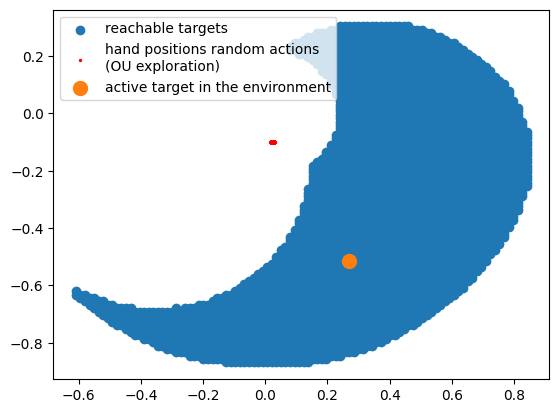

In [ ]:
import matplotlib.pyplot as plt

agent = SACAgent(state_dim, action_dim, hidden_layers, device=device)
env = SequentialReachingEnv(
    xml_file="arm_model.xml",
    max_num_targets=1,
    max_target_duration=3,
)

targets = env.reachable_positions.to_numpy()

plt.scatter(targets[:,0], targets[:,2])

# uncomment below if you want to visualize the result of the training
state, _ = env.reset()
done = False
N = 1000
hand_pos = np.zeros((N,3))
actions = np.zeros((N,4))

for i in range(N):
   action = agent.select_action(state, deterministic=False)
   action = (action + 1) / 2
   actions[i,:] = action
   next_state, reward, terminated, truncated, info, hp = env.step(action)
   hand_pos[i,:] = hp
   done = terminated or truncated
   state = next_state
env.close()

plt.scatter(hand_pos[:,0], hand_pos[:,2], c = 'red',s = 2)
env.target_positions
plt.scatter(env.target_positions[0][0],env.target_positions[0][2], s = 100 )
plt.legend(['reachable targets', 'hand positions random actions \n(OU exploration)','active target in the environment'])